## Apply TDA on retina data

**The following code includes:**

 1. dimensionality reduction using diffusion maps 
* diffusion map: pydiffmap

https://pydiffmap.readthedocs.io/en/master/usage.html


 2. generate both persistence barcodes and persistence diagrams from the resulting 3D point clouds for six stimuli types
 
 * persistence diagram: ripser (https://ripser.scikit-tda.org/en/latest/index.html)

* persistence barcode: persim 
    * https://persim.scikit-tda.org/en/latest/index.html
    * https://github.com/scikit-tda/persim/pull/24
    * https://github.com/scikit-tda/persim/blob/4702251c22d4fffbb1c29409f466745c6b6c26c5/persim/visuals.py 

 3. Compute the pairwise Wasserstein distance between the persistence diagrams:

* package used: gudhi hera

* useful reference: https://github.com/giotto-ai/giotto-tda/issues/603

In [1]:
import persim

In [2]:
# Basic imports 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
# from IPython.display import Video

# scikit-tda imports..... Install all with -> pip install scikit-tda
#--- this is the main persistence computation workhorse
import ripser
# from persim import plot_diagrams
import persim
# import persim.plot

# teaspoon imports...... Install with -> pip install teaspoon
#---these are for generating data and some drawing tools 
import teaspoon.MakeData.PointCloud as makePtCloud
import teaspoon.TDA.Draw as Draw

#---these are for generating time series network examples
from teaspoon.SP.network import ordinal_partition_graph
from teaspoon.TDA.PHN import PH_network
from teaspoon.SP.network_tools import make_network
from teaspoon.parameter_selection.MsPE import MsPE_tau
import teaspoon.MakeData.DynSysLib.DynSysLib as DSL

In [3]:
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from kmapper import jupyter 
import pydiffmap
from pydiffmap import diffusion_map as dm
from pydiffmap.visualization import embedding_plot, data_plot

In [4]:
# import dionysus as ds
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import pylab as pl
from matplotlib import collections  as mc
from sklearn.datasets import load_digits
from skimage.morphology import skeletonize
import math
import sys

In [5]:
from scipy.io import loadmat
retina_original_data = loadmat('retina-201205_bgonlyb50RelNormconsecDel142.mat')['X']
retina_original_data.shape

(698, 6, 264)

## Draw barcode diagrmas:

In [6]:
class Barcode:
    __doc__ = """
        Barcode visualisation made easy!
        Note that this convenience class requires instantiation as the number
        of subplots produced depends on the dimension of the data.
        """

    def __init__(self, diagrams, verbose=False):
        """
        Parameters
        ===========
        diagrams: list-like
            typically the output of ripser(nodes)['dgms']
        verbose: bool
            Execute print statemens for extra information; currently only echoes
            number of bars in each dimension (Default=False).
        Examples
        ===========
        >>> n = 300
        >>> t = np.linspace(0, 2 * np.pi, n)
        >>> noise = np.random.normal(0, 0.1, size=n)
        >>> data = np.vstack([((3+d) * np.cos(t[i]+d), (3+d) * np.sin(t[i]+d)) for i, d in enumerate(noise)])
        >>> diagrams = ripser(data)
        >>> bc = Barcode(diagrams['dgms'])
        >>> bc.plot_barcode()
        """
        if not isinstance(diagrams, list):
            diagrams = [diagrams]

        self.diagrams = diagrams
        self._verbose = verbose
        self._dim = len(diagrams)

    def plot_barcode(self, figsize=None, show=True, export_png=False, dpi=100, **kwargs):
        """Wrapper method to produce barcode plot
        Parameters
        ===========
        figsize: tuple
            figure size, default=(6,6) if H0+H1 only, (6,4) otherwise
        show: boolean
            show the figure via plt.show()
        export_png: boolean
            write image to png data, returned as io.BytesIO() instance,
            default=False
        **kwargs: artist paramters for the barcodes, defaults:
            c='grey'
            linestyle='-'
            linewidth=0.5
            dpi=100 (for png export)
        Returns
        ===========
        out: list or None
            list of png exports if export_png=True, otherwise None
        """
        if self._dim == 2:
            if figsize is None:
                figsize = (6, 6)

            return self._plot_H0_H1(
                figsize=figsize,
                show=show,
                export_png=export_png,
                dpi=dpi,
                **kwargs
            )

        else:
            if figsize is None:
                figsize = (6, 4)

            return self._plot_Hn(
                figsize=figsize,
                show=show,
                export_png=export_png,
                dpi=dpi,
                **kwargs
            )

    def _plot_H0_H1(self, *, figsize, show, export_png, dpi, **kwargs):
        out = []

        fig, ax = plt.subplots(2, 1, figsize=figsize)

        for dim, diagram in enumerate(self.diagrams):
            self._plot_many_bars(dim, diagram, dim, ax, **kwargs)

        if export_png:
            fp = io.BytesIO()
            plt.savefig(fp, dpi=dpi)
            fp.seek(0)

            out += [fp]

        if show:
            plt.show()
        else:
            plt.close()

        if any(out):
            return out

    def _plot_Hn(self, *, figsize, show, export_png, dpi, **kwargs):
        out = []

        for dim, diagram in enumerate(self.diagrams):
            fig, ax = plt.subplots(1, 1, figsize=figsize)

            self._plot_many_bars(dim, diagram, 0, [ax], **kwargs)

            if export_png:
                fp = io.BytesIO()
                plt.savefig(fp, dpi=dpi)
                fp.seek(0)

                out += [fp]

            if show:
                plt.show()
            else:
                plt.close()

        if any(out):
            return out

    def _plot_many_bars(self, dim, diagram, idx, ax, **kwargs):
        number_of_bars = len(diagram)
        if self._verbose:
            print("Number of bars in dimension %d: %d" % (dim, number_of_bars))

        if number_of_bars > 0:
            births = np.vstack([(elem[0], i) for i, elem in enumerate(diagram)])
            deaths = np.vstack([(elem[1], i) for i, elem in enumerate(diagram)])

            inf_bars = np.where(np.isinf(deaths))[0]
            max_death = deaths[np.isfinite(deaths[:, 0]), 0].max()

            number_of_bars_fin = births.shape[0] - inf_bars.shape[0]
            number_of_bars_inf = inf_bars.shape[0]

            _ = [self._plot_a_bar(ax[idx], birth, deaths[i], max_death, **kwargs) for i, birth in enumerate(births)]

        # the line below is to plot a vertical red line showing the maximal finite bar length
        ax[idx].plot(
            [max_death, max_death],
            [0, number_of_bars - 1],
            c='r',
            linestyle='--',
            linewidth=0.7
        )

        title = "H%d barcode: %d finite, %d infinite" % (dim, number_of_bars_fin, number_of_bars_inf)
        ax[idx].set_title(title, fontsize=9)
        ax[idx].set_yticks([])

        for loc in ('right', 'left', 'top'):
            ax[idx].spines[loc].set_visible(False)

    @staticmethod
    def _plot_a_bar(ax, birth, death, max_death, c='gray', linestyle='-', linewidth=0.5):
        if np.isinf(death[0]):
            death[0] = 1.05 * max_death
            ax.plot(
                death[0],
                death[1],
                c=c,
                markersize=4,
                marker='>',
            )

        ax.plot(
            [birth[0], death[0]],
            [birth[1], death[1]], 
            c=c,
            linestyle=linestyle,
            linewidth=linewidth,
        )

## Draw persistent diagrams:

In [7]:
## My code from here:

def drawTDAtutorial(P,diagrams, R):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,5))
    
    # Draw diagrams
    plt.sca(axes[0])
    plt.title('0-dim Diagram')
    Draw.drawDgm(diagrams[0])
#     R = max(diagrams[0][1])
    plt.axis([0,R,0,R])
    
    plt.sca(axes[1])
    plt.title('1-dim Diagram')
    Draw.drawDgm(diagrams[1])
#     R = max(diagrams[1][1])
    plt.axis([0,R,0,R])
    
    plt.sca(axes[2])
    plt.title('2-dim Diagram')
    Draw.drawDgm(diagrams[2])
#     R = max(diagrams[2][1])
    plt.axis([0,R,0,R])


## Dimensionality reduction and TDA: 

pydiffmap:
n_evecs is the number of eigenvectors that are computed, epsilon is a scale parameter used to rescale distances between data points, alpha is a normalization parameter (typically between 0.0 and 1.0) that influences the effect of the sampling density, and k is the number of nearest neighbors considered when the kernel is computed. A larger k means increased accuracy but larger computation time

In [8]:
def diffusion_tda(X):
  ## diffusion map with automatic epsilon detection:
    mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 3, alpha = 1, epsilon =  1.0 , k=100)

  # Fit to and transform the data
    X_dmap = mydmap.fit_transform(X)
  
    embedding_plot(mydmap, dim=3, scatter_kwargs = {'c': X_dmap[:,0], 'cmap': 'Spectral'})
    data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})
    plt.show()
    print("SHAPE",X_dmap.shape)

    ax = plt.axes(projection ="3d")
    ax.scatter3D(X_dmap[:,0], X_dmap[:,1], X_dmap[:,2])
    plt.show()

#     plt.scatter(X_dmap[:,0], X_dmap[:,1])
#     plt.show()
    
    X_diagrams = ripser.ripser(X_dmap, maxdim = 2)['dgms']

  ## draw persistence diagrams
    drawTDAtutorial(X_dmap,X_diagrams,R=0.1) 

  ## draw persistence barcodes
    Barcode(X_diagrams).plot_barcode()
    
    return X_diagrams, Barcode(X_diagrams)

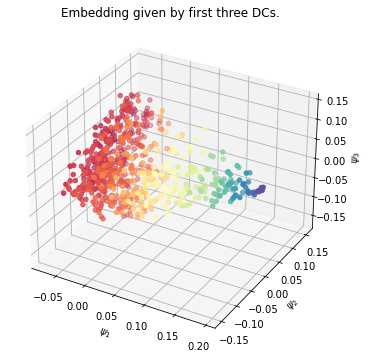

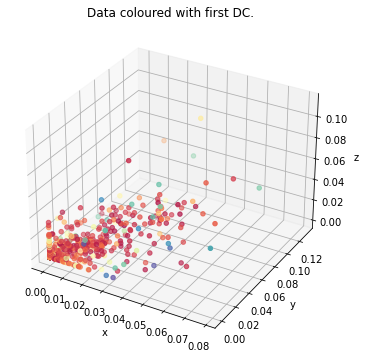

SHAPE (698, 3)


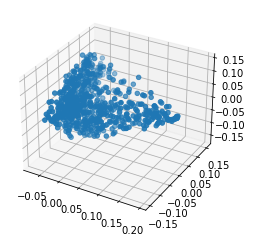

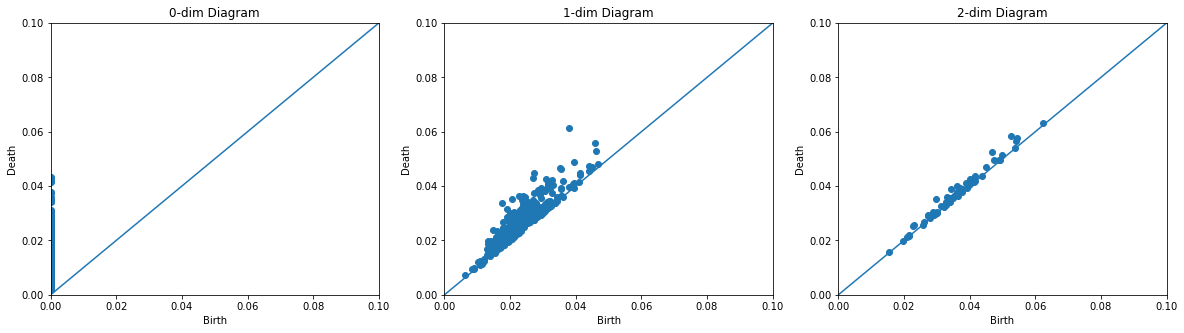

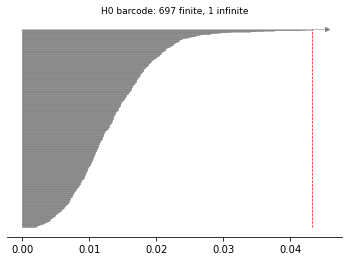

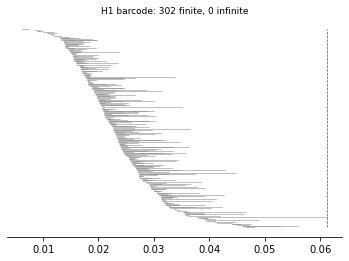

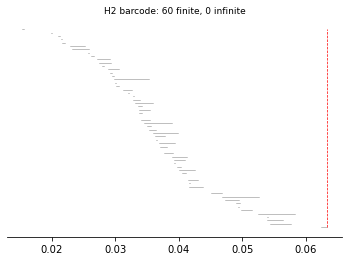

In [9]:
X1 = retina_original_data[:,0,:]
X1.shape
X1_diagrams, X1_barcode = diffusion_tda(X1)

## isomap what info is lost and the specific distance measure
## possible loss of info: analyze and say something
## show the barcode


## compare with the traditional method: directly compute the distance between
## metric space: 698 points 
# dsitance between two sequence of images
# two distance between images 
# compare some of the distances
# goromov hausdorff distance between barcodes - carlsson review
# observe the diff compared to traditional distance

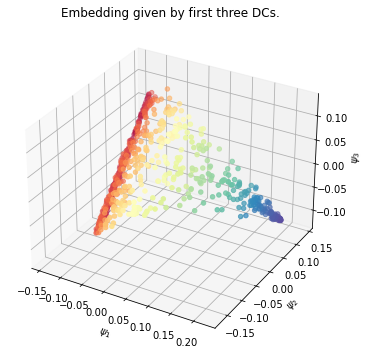

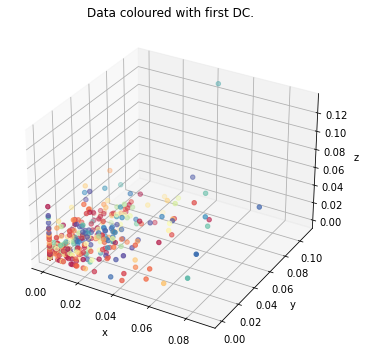

SHAPE (698, 3)


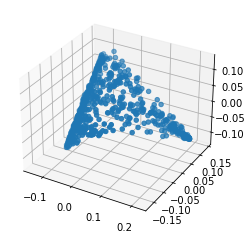

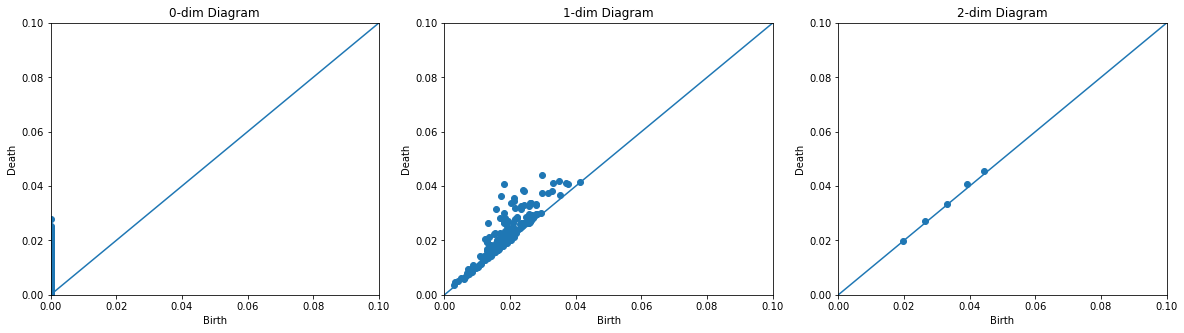

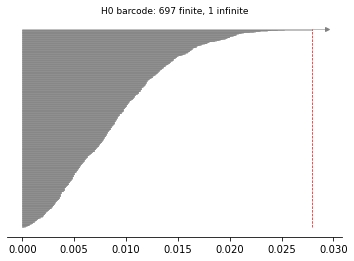

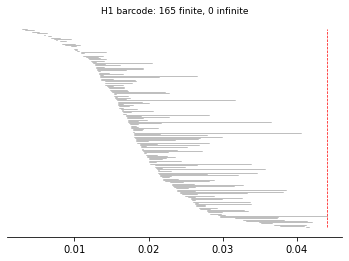

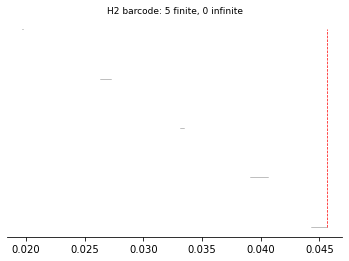

In [10]:
X2 = retina_original_data[:,1,:]
X2_diagrams, X2_barcode = diffusion_tda(X2)

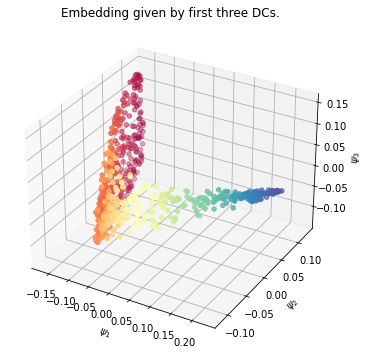

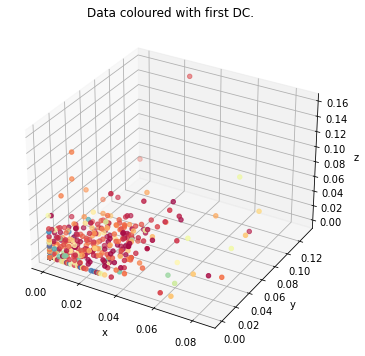

SHAPE (698, 3)


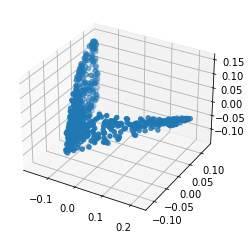

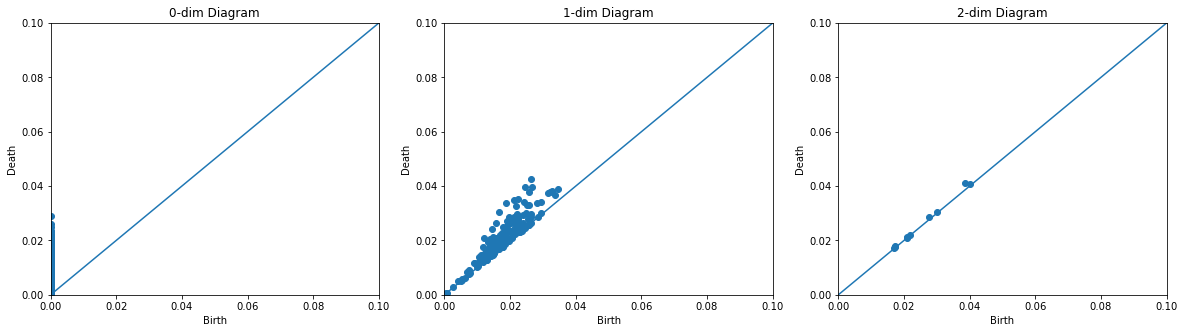

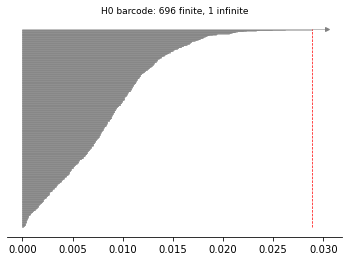

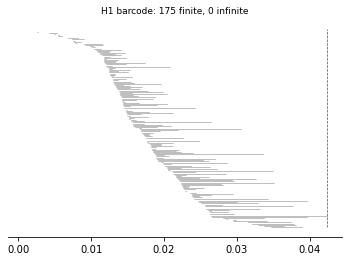

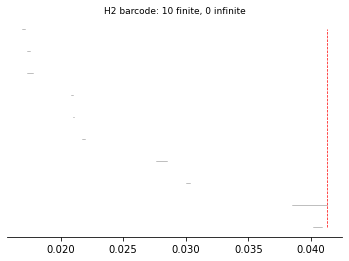

In [11]:
X3 = retina_original_data[:,2,:]
X3_diagrams, X3_barcode = diffusion_tda(X3)

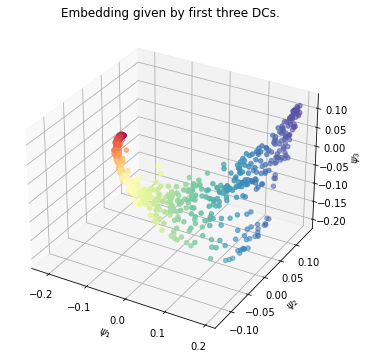

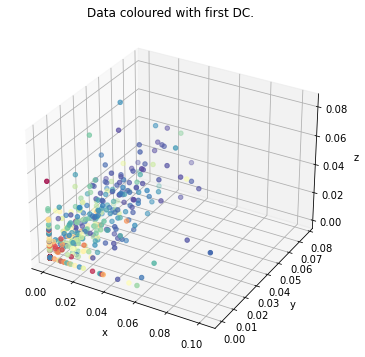

SHAPE (698, 3)


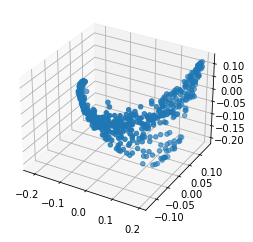

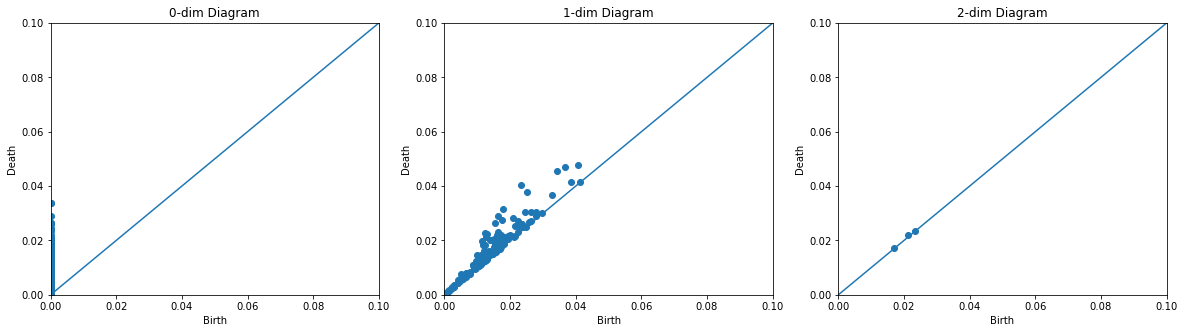

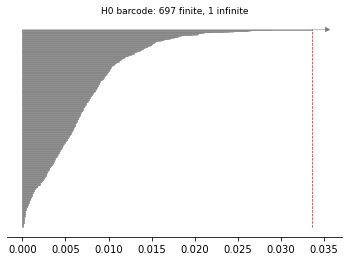

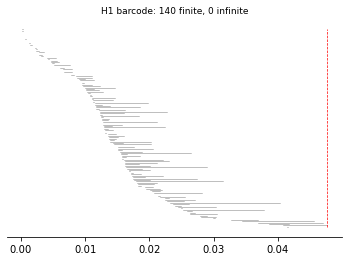

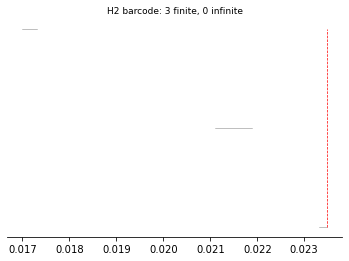

In [12]:
X4 = retina_original_data[:,3,:]

X4_diagrams, X4_barcode = diffusion_tda(X4)

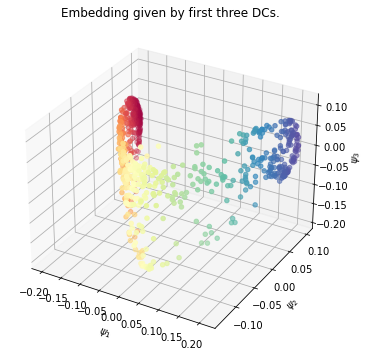

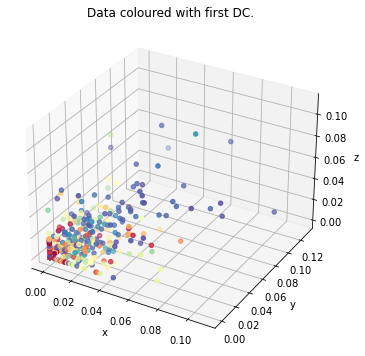

SHAPE (698, 3)


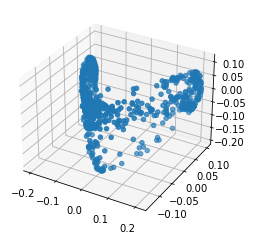

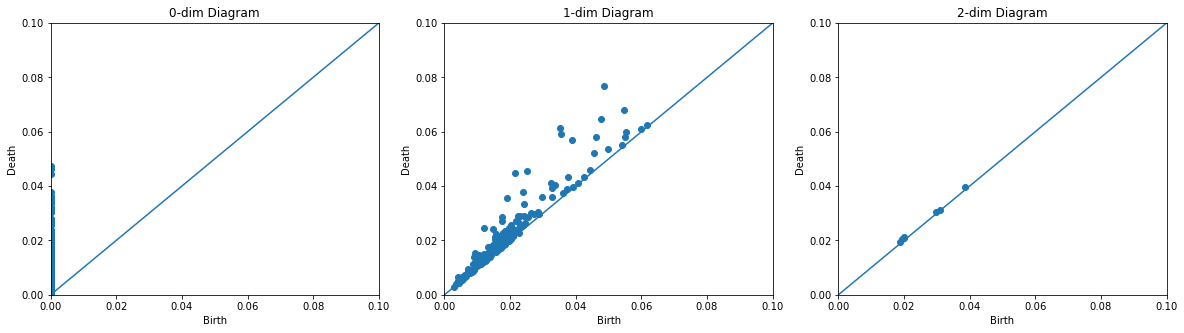

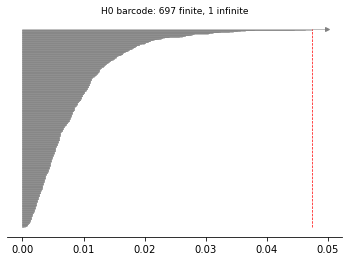

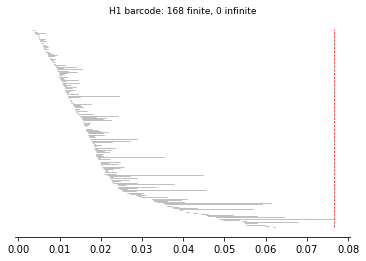

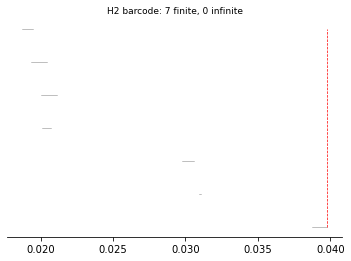

In [13]:
X5 = retina_original_data[:,4,:]


X5_diagrams, X5_barcode = diffusion_tda(X5)

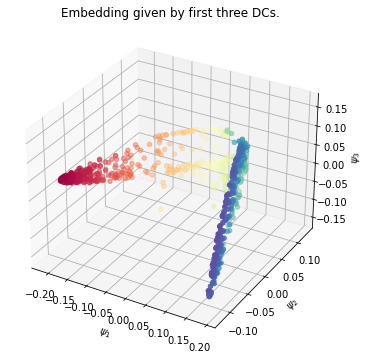

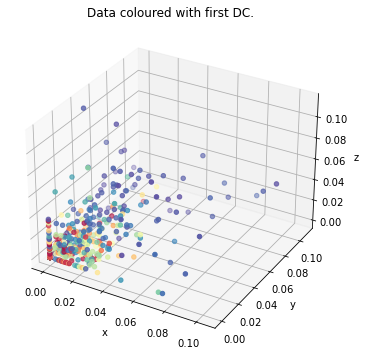

SHAPE (698, 3)


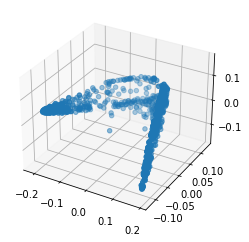

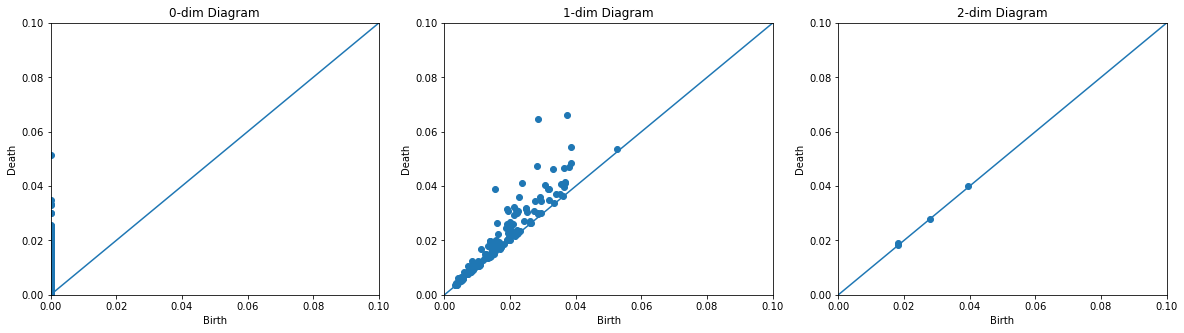

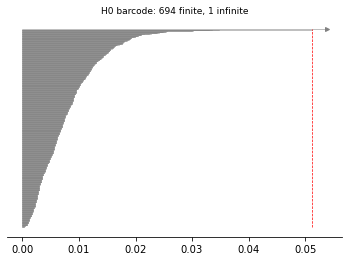

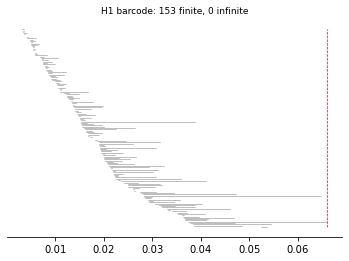

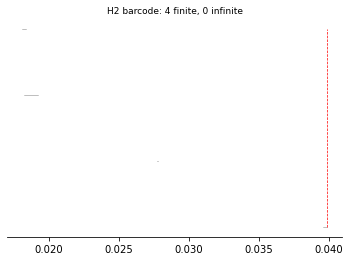

In [14]:
X6 = retina_original_data[:,5,:]

X6_diagrams, X6_barcode = diffusion_tda(X6)

## Compute the pairwise Wasserstein distance:

useful resource: https://github.com/giotto-ai/giotto-tda/issues/603

### first check that Wasserstein distance computed by two packages are the same:

In [15]:
from gtda.diagrams import PairwiseDistance
pd = PairwiseDistance(['wasserstein'])

In [16]:
pd_X1_X2_persim = persim.wasserstein(X1_diagrams[0], X2_diagrams[0])

C:\Users\ifisa\anaconda3\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
C:\Users\ifisa\anaconda3\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


In [17]:
pd_X1_X2_persim

2.7718896795122

In [18]:
## check that the result is consistent with the persim package:
from gudhi.wasserstein import wasserstein_distance
from gudhi.hera import wasserstein_distance as hera
pd_X1_X2_gudhi = hera(X1_diagrams[0], X2_diagrams[0],internal_p=2)
pd_X1_X2_gudhi

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT


2.7719287214918436

### Compute all pairwise distance between the six point clouds:

In [95]:
from gudhi.wasserstein import wasserstein_distance
from gudhi.hera import wasserstein_distance as hera
X_diagrams = []
X_diagrams.append(X1_diagrams)
X_diagrams.append(X2_diagrams)
X_diagrams.append(X3_diagrams)
X_diagrams.append(X4_diagrams)
X_diagrams.append(X5_diagrams)
X_diagrams.append(X6_diagrams)

pd_gudhi = np.zeros((6,6,3))
for dim in range(3):
    print(dim)
    print("-------------------")
    for i in range(6):
        print("$X" + "_" + str(i+1) + '$ &')
        for j in range(6):
#             if i != j:
            pd_gudhi[i,j,dim] = hera(X_diagrams[i][dim], X_diagrams[j][dim],internal_p=2)
#                 print('Wasserstein distance between persistence diagrams for' + str(i+1) +' and '+ str(j+1) + ' (H' + str(dim) + ') is:')
            print(str(float("{0:.2f}".format(pd_gudhi[i,j,dim])))+'&')
        print("\\" + "\\")
        print("\hline") 

0
-------------------
$X_1$ &
0.0&
2.77&
3.05&
3.95&
3.08&
3.42&
\\
\hline
$X_2$ &
2.77&
0.0&
0.43&
1.35&
1.0&
0.84&
\\
\hline
$X_3$ &
3.05&
0.43&
0.0&
1.03&
0.94&
0.66&
\\
\hline
$X_4$ &
3.95&
1.35&
1.03&
0.0&
1.11&
0.72&
\\
\hline
$X_5$ &
3.08&
1.0&
0.94&
1.11&
0.0&
0.51&
\\
\hline
$X_6$ &
3.42&
0.84&
0.66&
0.72&
0.51&
0.0&
\\
\hline
1
-------------------
$X_1$ &
0.0&
0.46&
0.5&
0.64&
0.64&
0.55&
\\
\hline
$X_2$ &
0.46&
0.0&
0.17&
0.29&
0.36&
0.3&
\\
\hline
$X_3$ &
0.5&
0.17&
0.0&
0.25&
0.33&
0.3&
\\
\hline
$X_4$ &
0.64&
0.29&
0.25&
0.0&
0.27&
0.29&
\\
\hline
$X_5$ &
0.64&
0.36&
0.33&
0.27&
0.0&
0.26&
\\
\hline
$X_6$ &
0.55&
0.3&
0.3&
0.29&
0.26&
0.0&
\\
\hline
2
-------------------
$X_1$ &
0.0&
0.06&
0.06&
0.06&
0.06&
0.06&
\\
\hline
$X_2$ &
0.06&
0.0&
0.01&
0.0&
0.01&
0.0&
\\
\hline
$X_3$ &
0.06&
0.01&
0.0&
0.0&
0.01&
0.0&
\\
\hline
$X_4$ &
0.06&
0.0&
0.0&
0.0&
0.0&
0.0&
\\
\hline
$X_5$ &
0.06&
0.01&
0.01&
0.0&
0.0&
0.0&
\\
\hline
$X_6$ &
0.06&
0.0&
0.0&
0.0&
0.0&
0.0&
\\
\hline


Pairwise Wasserstein distance between persistence diagrams for homology group $H_0$:

In [20]:
print(pd_gudhi[:,:,0])

[[0.         2.77192872 3.04745634 3.95276261 3.07892065 3.41508927]
 [2.77192524 0.         0.42930521 1.34856909 0.99806364 0.84377773]
 [3.04747962 0.42930766 0.         1.03143331 0.94296253 0.65615236]
 [3.95283538 1.34850632 1.0315476  0.         1.10848366 0.72082808]
 [3.07892922 0.99806358 0.94295643 1.10848369 0.         0.51151537]
 [3.41507195 0.84376872 0.65615035 0.72081878 0.51151656 0.        ]]


Pairwise Wasserstein distance between persistence diagrams for homology group $H_1$:

In [21]:
print(pd_gudhi[:,:,1])

[[0.         0.45973786 0.50093082 0.64066787 0.63832201 0.54722478]
 [0.45974146 0.         0.16690206 0.29471953 0.36368453 0.30304126]
 [0.50092305 0.1668978  0.         0.24557967 0.33290296 0.29892867]
 [0.64068023 0.29472335 0.24558021 0.         0.26870174 0.28557107]
 [0.63833715 0.36368295 0.33290654 0.26869569 0.         0.26458892]
 [0.54724428 0.30303734 0.29893539 0.28556935 0.26458771 0.        ]]


Pairwise Wasserstein distance between persistence diagrams for homology group $H_2$:

In [22]:
print(pd_gudhi[:,:,2])

[[0.         0.05800773 0.05728896 0.0593703  0.06085189 0.0596126 ]
 [0.05800773 0.         0.00500477 0.00380341 0.00596403 0.0036489 ]
 [0.05728896 0.00500477 0.         0.00485482 0.00647532 0.00494322]
 [0.0593703  0.00380341 0.00485482 0.         0.00479106 0.00202047]
 [0.06085189 0.00596403 0.00647532 0.00479106 0.         0.00432514]
 [0.0596126  0.0036489  0.00494322 0.00202047 0.00432514 0.        ]]


### compare with known shape, eg a circle:

In [23]:
import tadasets

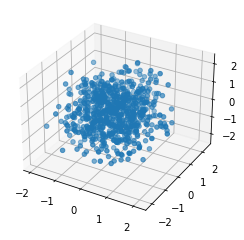

In [24]:
dsphere = tadasets.dsphere(n=698, d=12, r=3.14, ambient=14, noise=0.14)
ax = plt.axes(projection ="3d")
ax.scatter3D(dsphere[:,0], dsphere[:,1], dsphere[:,2])
plt.show()

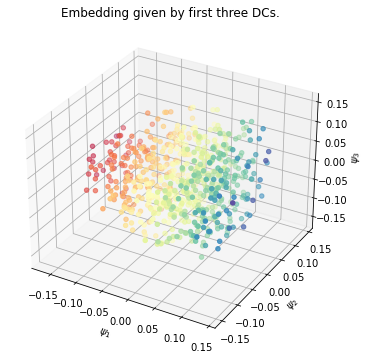

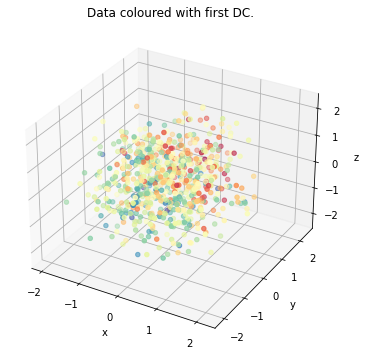

SHAPE (698, 3)


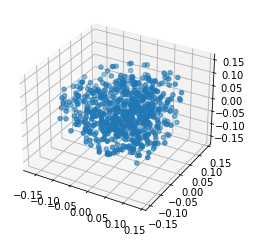

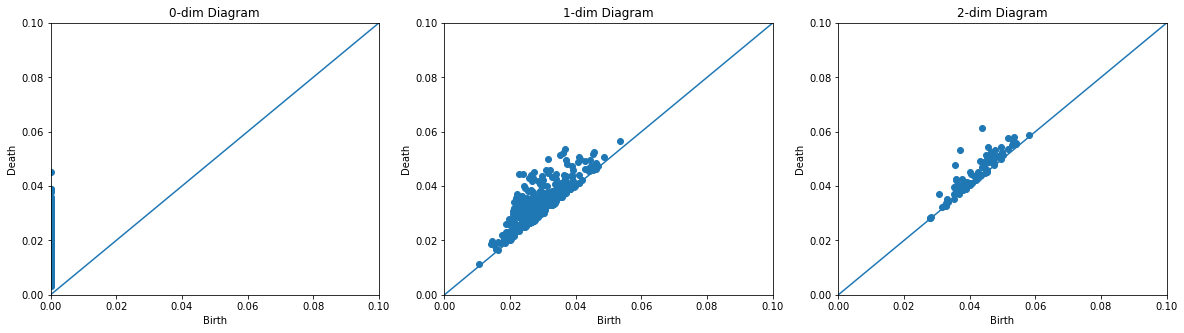

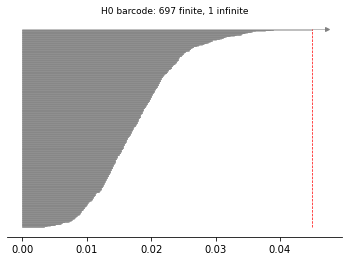

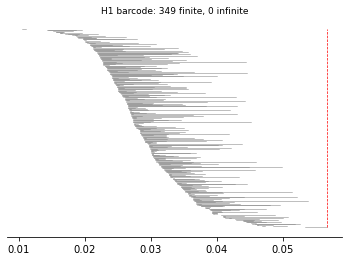

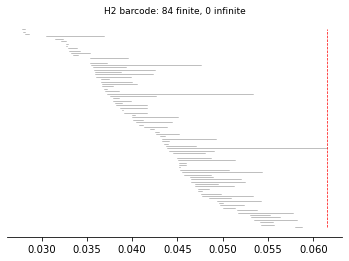

In [25]:
dsphere_diagrams, dsphere_barcode = diffusion_tda(dsphere)

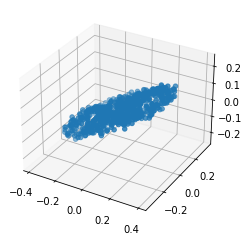

In [26]:
torus = tadasets.torus(n=698, c=2, a=1, ambient=200, noise=0.2)
ax = plt.axes(projection ="3d")
ax.scatter3D(torus[:,0], torus[:,1], torus[:,2])
plt.show()

In [42]:
class TorusSampler():

    def __init__(self, r=1, R=3, x0=0, y0=0, z0=0):
        self._r = r
        self._R = R
        self._x0 = x0
        self._y0 = y0
        self._z0 = z0
    
    '''
    This sampling may not be uniform
    '''
    def Sample(self, n):
        u = 2 * np.pi * np.random.rand(n)
        v = 2 * np.pi * np.random.rand(n)

        cosu = np.cos(u)
        sinu = np.sin(u)

        cosv = np.cos(v)
        sinv = np.sin(v)

        x = self._x0 + (self._R + self._r * cosu) * cosv
        y = self._y0 + (self._R + self._r * cosu) * sinv
        z = self._z0 + self._r * sinu

        return np.array([x, y, z]).T

In [77]:
torus = TorusSampler(1, 3).Sample(698)

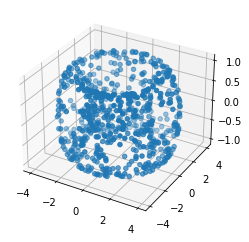

In [78]:
ax = plt.axes(projection ="3d")
ax.scatter3D(torus[:,0], torus[:,1], torus[:,2])
plt.show()

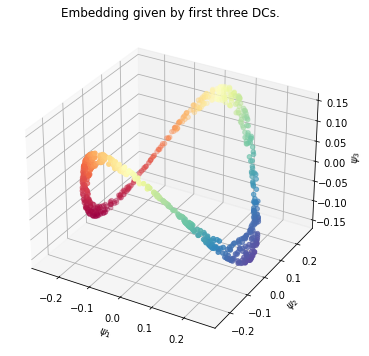

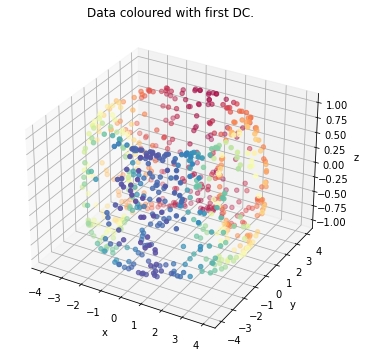

SHAPE (698, 3)


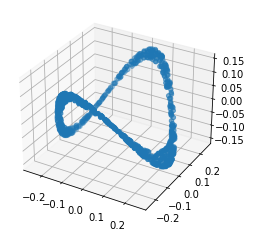

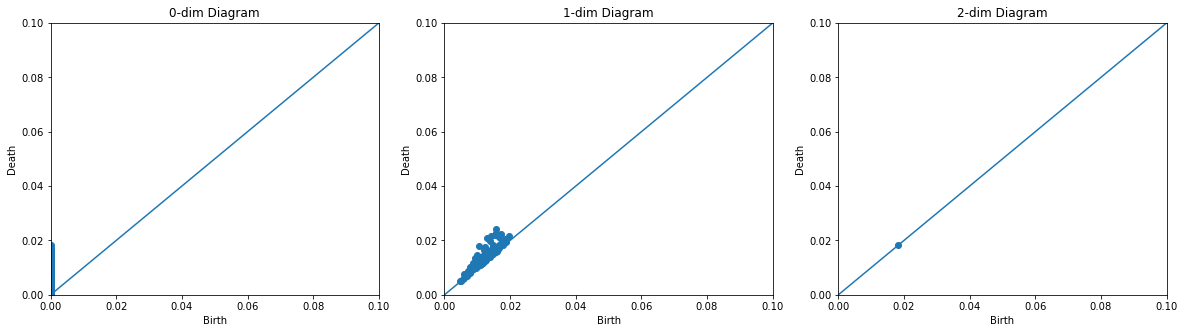

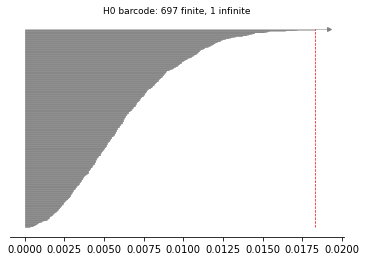

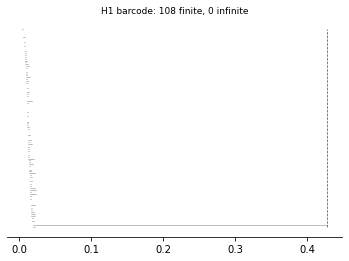

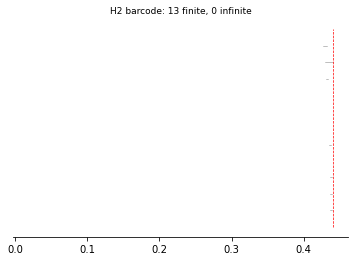

In [79]:
torus_diagrams, torus_barcode = diffusion_tda(torus)

In [76]:
from gudhi.wasserstein import wasserstein_distance
from gudhi.hera import wasserstein_distance as hera
X_diagrams = []
X_diagrams.append(X1_diagrams)
X_diagrams.append(X2_diagrams)
X_diagrams.append(X3_diagrams)
X_diagrams.append(X4_diagrams)
X_diagrams.append(X5_diagrams)
X_diagrams.append(X6_diagrams)

pd_dsphere_gudhi = np.zeros((6,3))
for dim in range(3):
    for i in range(6):
#         print(X_diagrams[i][dim])
#         print(dsphere_diagrams[dim])
        pd_dsphere_gudhi[i,dim] = hera(X_diagrams[i][dim], dsphere_diagrams[dim])
        print('Wasserstein distance between persistence diagrams for circle and point cloud ' + str(i+1) + ' (H' + str(dim) + ') is:')
        print(pd_dsphere_gudhi[i,dim])

Wasserstein distance between persistence diagrams for circle and point cloud 1 (H0) is:
2.4809560721041635
Wasserstein distance between persistence diagrams for circle and point cloud 2 (H0) is:
4.463884397916445
Wasserstein distance between persistence diagrams for circle and point cloud 3 (H0) is:
4.641338810155503
Wasserstein distance between persistence diagrams for circle and point cloud 4 (H0) is:
5.17980453916789
Wasserstein distance between persistence diagrams for circle and point cloud 5 (H0) is:
4.531922676127579
Wasserstein distance between persistence diagrams for circle and point cloud 6 (H0) is:
4.827321461983956
Wasserstein distance between persistence diagrams for circle and point cloud 1 (H1) is:
0.6241310045588762
Wasserstein distance between persistence diagrams for circle and point cloud 2 (H1) is:
0.7671945061301813
Wasserstein distance between persistence diagrams for circle and point cloud 3 (H1) is:
0.7996520071465056
Wasserstein distance between persistence di

In [80]:
from gudhi.wasserstein import wasserstein_distance
from gudhi.hera import wasserstein_distance as hera
X_diagrams = []
X_diagrams.append(X1_diagrams)
X_diagrams.append(X2_diagrams)
X_diagrams.append(X3_diagrams)
X_diagrams.append(X4_diagrams)
X_diagrams.append(X5_diagrams)
X_diagrams.append(X6_diagrams)

pd_torus_gudhi = np.zeros((6,3))
for dim in range(3):
    for i in range(6):
#         print(X_diagrams[i][dim])
#         print(dsphere_diagrams[dim])
        pd_torus_gudhi[i,dim] = hera(X_diagrams[i][dim], torus_diagrams[dim])
        print('Wasserstein distance between persistence diagrams for circle and point cloud ' + str(i+1) + ' (H' + str(dim) + ') is:')
        print(pd_torus_gudhi[i,dim])

Wasserstein distance between persistence diagrams for circle and point cloud 1 (H0) is:
3.6310234030825086
Wasserstein distance between persistence diagrams for circle and point cloud 2 (H0) is:
1.4639444853646637
Wasserstein distance between persistence diagrams for circle and point cloud 3 (H0) is:
1.3077519815615233
Wasserstein distance between persistence diagrams for circle and point cloud 4 (H0) is:
0.7306229655132483
Wasserstein distance between persistence diagrams for circle and point cloud 5 (H0) is:
1.3777969512157142
Wasserstein distance between persistence diagrams for circle and point cloud 6 (H0) is:
1.0552870598621666
Wasserstein distance between persistence diagrams for circle and point cloud 1 (H1) is:
0.7361079549882561
Wasserstein distance between persistence diagrams for circle and point cloud 2 (H1) is:
0.48583426291588694
Wasserstein distance between persistence diagrams for circle and point cloud 3 (H1) is:
0.4428885536908638
Wasserstein distance between persist

In [97]:
print("Comparing six point-clouds with 3-sphere (H0):")
print(pd_dsphere_gudhi[:,0])
print("Comparing six point-clouds with torus (H0):")
print(pd_torus_gudhi[:,0])

Comparing six point-clouds with 3-sphere (H0):
[2.48095607 4.4638844  4.64133881 5.17980454 4.53192268 4.82732146]
Comparing six point-clouds with torus (H0):
[3.6310234  1.46394449 1.30775198 0.73062297 1.37779695 1.05528706]


In [82]:
print("Comparing six point-clouds with 3-sphere (H1):")
print(pd_dsphere_gudhi[:,1])
print("Comparing six point-clouds with torus (H1):")
print(pd_torus_gudhi[:,1])

Comparing six point-clouds with 3-sphere (H1):
[0.624131   0.76719451 0.79965201 0.86659185 0.84960046 0.76461896]
Comparing six point-clouds with torus (H1):
[0.73610795 0.48583426 0.44288855 0.33952863 0.45408775 0.46878553]


In [83]:
print("Comparing six point-clouds with 3-sphere (H2):")
print(pd_dsphere_gudhi[:,2])
print("Comparing six point-clouds with torus (H2):")
print(pd_torus_gudhi[:,2])

Comparing six point-clouds with 3-sphere (H2):
[0.109864   0.12334375 0.12340328 0.12458729 0.12582713 0.12466538]
Comparing six point-clouds with torus (H2):
[0.05699422 0.01747226 0.01839379 0.01604395 0.01817796 0.01596159]
